In [1]:
import sys
from time import time
from scipy import stats, sparse
from scipy.sparse.linalg import svds, eigs
from scipy.special import expit
import numpy as np
import os
import math
from sklearn.preprocessing import normalize
from sklearn.manifold import TSNE
from sklearn.metrics import precision_recall_curve
from sklearn import metrics
import collections
import scipy
from scipy.stats import norm as dist_model
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.cross_decomposition import CCA
import pandas as pd
import matplotlib.ticker as mtick
from matplotlib.colors import ListedColormap
from collections import defaultdict
import seaborn as sns
from scipy.stats import gaussian_kde
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec
import pickle as pkl

#from utils import *
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib import cm
from matplotlib.ticker import FormatStrFormatter
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

#Lemur 1 = Bernard (male); Lemur 2 = Stumpy (female); Lemur 3 = Martine (female); Lemur 4 = Antoine (male)
MEDIUM_SIZE = 8
SMALLER_SIZE = 6
plt.rc('font', size=MEDIUM_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('axes', titlesize=MEDIUM_SIZE)	 # fontsize of the axes title
plt.rc('xtick', labelsize=SMALLER_SIZE)	# fontsize of the tick labels
plt.rc('ytick', labelsize=SMALLER_SIZE)	# fontsize of the tick labels
plt.rc('figure', titlesize=MEDIUM_SIZE)
plt.rc('legend', fontsize=MEDIUM_SIZE)
plt.rc('font', family='Helvetica')
plt.rc('mathtext', default='regular')
def format_ax(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
FIG_HEIGHT = 2
FIG_WIDTH = 2
dname2keyword = {'muris_facs':'Muris FACS','muris_droplet':'Muris droplet','allen':'Allen',
'microcebusAntoine':'Lemur 4','microcebusBernard':'Lemur 1','microcebusMartine':'Lemur 3','microcebusStumpy':'Lemur 2'}
dname2keyword_raw = {'muris_facs':'Muris FACS','muris_droplet':'Muris droplet','allen':'Allen',
'microcebusAntoine':'Lemur 4','microcebusBernard':'Lemur 1','microcebusMartine':'Lemur 3','microcebusStumpy':'Lemur 2'}
for dname in dname2keyword_raw:
    st = dname2keyword[dname]
    dname2keyword[dname] = ''
    for i in range(len('Muris droplet') - len(st)):
        dname2keyword[dname] += ' '
    dname2keyword[dname] += st
dnames = ['muris_facs','muris_droplet','microcebusBernard','microcebusStumpy','microcebusMartine','microcebusAntoine']
print(matplotlib.matplotlib_fname())


/home/disk2/yjw/miniconda3/envs/Scorpius/lib/python3.8/site-packages/matplotlib/mpl-data/matplotlibrc


findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


F_onewayResult(statistic=209.82879482774754, pvalue=7.611124164207846e-79)

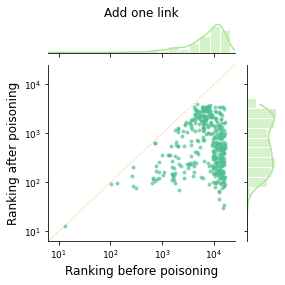

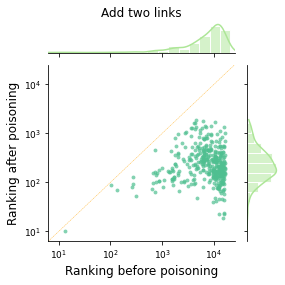

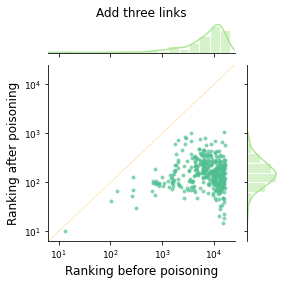

In [3]:

from scipy.stats import linregress, t

def scatter_plot(ax, x, y, xlabel='', ylabel='', s_scale=1):
    xy = np.vstack([x, y])
    sc = ax.scatter(x, y, s=s_scale*get_scatter_plot_setting()['s']*1.5, \
        c='#4fbf90', cmap=get_scatter_plot_setting()['cmap'], alpha=0.7,
        linewidths = 0)
    # plt.colorbar(sc, ax=ax)
    format_ax(ax)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

def add_confidence_level(x, y, ax):
    sns.regplot(x=x, y=y, ci=95, scatter=False, ax=ax, color='w')

def get_scatter_plot_setting():

    return {
        's': 10,
        'cmap': 'bone',
        'hist_cmap': 'bone',
        'hist_bins': 20,
        'hist_range': (0.9, 4.4),
        'hist_bin_width': 0.2,
        'hist_color': '#ade697',
    }

def hist_scatter_plot_rankchange(preds, labels, fig_suffix='.pdf', K = 1):
    # fig = get_scatter_plot_axis ()
    fig = plt.figure(figsize=(FIG_WIDTH * 2, FIG_HEIGHT * 2))
    # plt.title('DistMult')
    # layout the grids for the scatter plot and the histogram plot
    gs = gridspec.GridSpec(2, 2, height_ratios=[1, 6], width_ratios=[6, 1])
    ax_scatter = plt.subplot(gs[1, 0])
    scatter_plot(ax_scatter, labels, preds)
    ax_scatter.set_xlabel('Ranking before poisoning', fontsize = SMALLER_SIZE*2)
    ax_scatter.set_ylabel('Ranking after poisoning', fontsize = SMALLER_SIZE*2)

    ax_scatter.set_xlim([0.8, 4.4])
    ax_scatter.set_ylim([0.8, 4.4])
    ax_scatter.set_xticks([1,  2, 3, 4], [r'$10^{1}$',  r'$10^{2}$', r'$10^{3}$', r'$10^{4}$'], fontsize = SMALLER_SIZE*1.5)
    ax_scatter.set_yticks([1,  2, 3, 4], [r'$10^{1}$',  r'$10^{2}$', r'$10^{3}$', r'$10^{4}$'], fontsize = SMALLER_SIZE*1.5)

    ax_scatter.plot(ax_scatter.get_xlim(), ax_scatter.get_ylim(), ls="--", c='orange', linewidth= 0.4, alpha = 0.9)
    # add_confidence_level(labels, preds, ax_scatter)
    # add the histogram plot
    ax_hist_x = plt.subplot(gs[0, 0], sharex=ax_scatter)

    sns.histplot(labels, ax=ax_hist_x, binwidth=get_scatter_plot_setting()['hist_bin_width'],\
        color=get_scatter_plot_setting()['hist_color'], kde=True, kde_kws={'cut': 3})
    
    titles = ['one link', 'two links', 'three links']
    plt.title(f'Add {titles[K-1]}', fontsize = SMALLER_SIZE*2)

    ax_hist_x.set_ylabel('')
    ax_hist_y = plt.subplot(gs[1, 1], sharey=ax_scatter)
    sns.histplot(y=preds, ax=ax_hist_y, \
        binwidth=get_scatter_plot_setting()['hist_bin_width'],\
        color=get_scatter_plot_setting()['hist_color'], kde=True)
    ax_hist_y.set_xlabel('')
    for patch in ax_hist_x.patches:
        patch.set_edgecolor('w')
    for patch in ax_hist_y.patches:
        patch.set_edgecolor('w')
    format_ax(ax_hist_x)
    format_ax(ax_hist_y)
    ax_hist_x.set_yticks([])
    ax_hist_y.set_xticks([])
    ax_hist_x.spines['left'].set_visible(False)
    ax_hist_y.spines['bottom'].set_visible(False)
    plt.setp(ax_hist_x.get_xticklabels(), visible=False)
    plt.setp(ax_hist_y.get_yticklabels(), visible=False)
    fig.tight_layout()
    fig.savefig(f'fig/{fig_suffix}', dpi = 300)

from scipy.stats import f_oneway
results = []
for suf,name in zip(['','2','3'], ['d', 'e', 'f']) :
    with open(f'../DiseaseAgnostic/results/After_distmult_0.7random{suf}.pkl', 'rb') as fl:
        edge = pkl.load(fl)
    with open('../DiseaseAgnostic/results/Init_0.7random.pkl', 'rb') as fl:
        init = pkl.load(fl)
    bioBART = edge
    results.append(bioBART)
    init =  np.log10(init)
    bioBART = np.log10(bioBART)
    if suf:
        K = int(suf)    
    else:
        K = 1
    hist_scatter_plot_rankchange(bioBART, init, fig_suffix=f'Fig2 {name}.pdf', K = K)
f_oneway(*results)

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


p value: 3.9275232899705264e-07
p value: 0.00020998479292536385
p value: 0.0015633527072653718
p value: 0.003772346552120369
p value: 0.007429189001555219
p value: 0.024892041950928923
p value: 0.04750391921060997
p value: 0.07285262699682785
p value: 0.15846903392488015


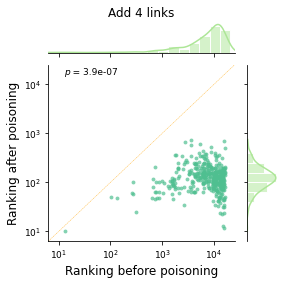

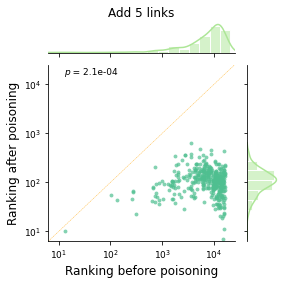

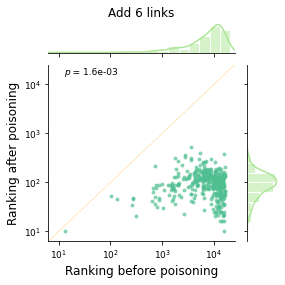

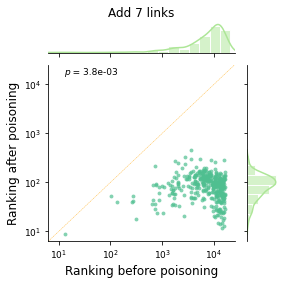

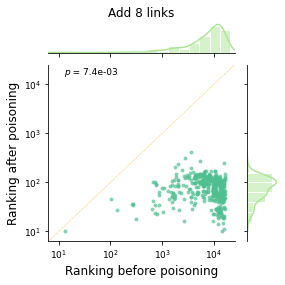

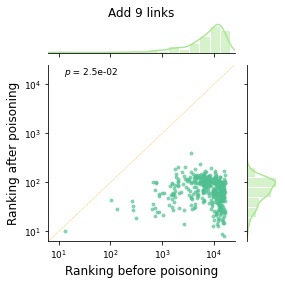

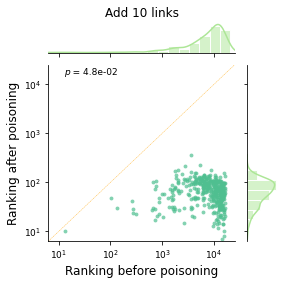

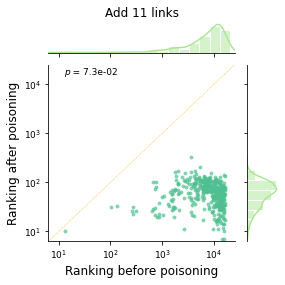

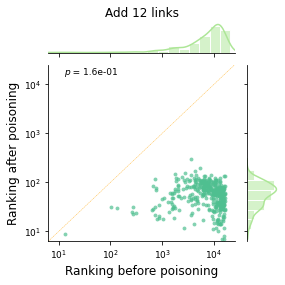

In [4]:

def hist_scatter_plot_rankchange(preds, labels, fig_suffix='.pdf', p_value = 0, K = 0):
    # fig = get_scatter_plot_axis ()
    fig = plt.figure(figsize=(FIG_WIDTH * 2, FIG_HEIGHT * 2))
    # plt.title('DistMult')
    # layout the grids for the scatter plot and the histogram plot
    gs = gridspec.GridSpec(2, 2, height_ratios=[1, 6], width_ratios=[6, 1])
    ax_scatter = plt.subplot(gs[1, 0])
    scatter_plot(ax_scatter, labels, preds)
    ax_scatter.set_xlabel('Ranking before poisoning', fontsize = SMALLER_SIZE*2)
    ax_scatter.set_ylabel('Ranking after poisoning', fontsize = SMALLER_SIZE*2)

    # set style  = italic
    ax_scatter.text(1.1, 4.2, 'p' , fontsize=SMALLER_SIZE*1.5, fontdict={'font': 'Helvetica', 'style': 'italic'})
    ax_scatter.text(1.1, 4.2, '   = {:.1e}'.format(p_value), fontsize=SMALLER_SIZE*1.5)

    ax_scatter.set_xlim([0.8, 4.4])
    ax_scatter.set_ylim([0.8, 4.4])
    ax_scatter.set_xticks([1,  2, 3, 4], [r'$10^{1}$',  r'$10^{2}$', r'$10^{3}$', r'$10^{4}$'], fontsize = SMALLER_SIZE*1.5)
    ax_scatter.set_yticks([1,  2, 3, 4], [r'$10^{1}$',  r'$10^{2}$', r'$10^{3}$', r'$10^{4}$'], fontsize = SMALLER_SIZE*1.5)

    ax_scatter.plot(ax_scatter.get_xlim(), ax_scatter.get_ylim(), ls="--", c='orange', linewidth= 0.4, alpha = 0.9)
    # add_confidence_level(labels, preds, ax_scatter)
    # add the histogram plot
    ax_hist_x = plt.subplot(gs[0, 0], sharex=ax_scatter)
    plt.title(f'Add {K} links', fontsize = SMALLER_SIZE*2)

    sns.histplot(labels, ax=ax_hist_x, binwidth=get_scatter_plot_setting()['hist_bin_width'],\
        color=get_scatter_plot_setting()['hist_color'], kde=True, kde_kws={'cut': 3})

    ax_hist_x.set_ylabel('')
    ax_hist_y = plt.subplot(gs[1, 1], sharey=ax_scatter)
    sns.histplot(y=preds, ax=ax_hist_y, \
        binwidth=get_scatter_plot_setting()['hist_bin_width'],\
        color=get_scatter_plot_setting()['hist_color'], kde=True)
    ax_hist_y.set_xlabel('')
    for patch in ax_hist_x.patches:
        patch.set_edgecolor('w')
    for patch in ax_hist_y.patches:
        patch.set_edgecolor('w')
    format_ax(ax_hist_x)
    format_ax(ax_hist_y)
    ax_hist_x.set_yticks([])
    ax_hist_y.set_xticks([])
    ax_hist_x.spines['left'].set_visible(False)
    ax_hist_y.spines['bottom'].set_visible(False)
    plt.setp(ax_hist_x.get_xticklabels(), visible=False)
    plt.setp(ax_hist_y.get_yticklabels(), visible=False)
    fig.tight_layout()
    fig.savefig(f'fig/{fig_suffix}', dpi=300)

from scipy.stats import ttest_ind

results = []
with open(f'../DiseaseAgnostic/results/After_distmult_0.7random{3}.pkl', 'rb') as fl:
    edge = pkl.load(fl)
results.append(edge)
for suf,name in zip(['4','5','6', '7', '8', '9', '10', '11', '12'], ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i']) :
    with open(f'../DiseaseAgnostic/results/After_distmult_0.7random{suf}.pkl', 'rb') as fl:
        edge = pkl.load(fl)
    with open('../DiseaseAgnostic/results/Init_0.7random.pkl', 'rb') as fl:
        init = pkl.load(fl)
    bioBART = edge
    results.append(bioBART)
    p = ttest_ind(results[-2], results[-1])[1]
    init =  np.log10(init)
    bioBART = np.log10(bioBART)
    print('p value:', p)
    hist_scatter_plot_rankchange(bioBART, init, p_value = p, fig_suffix=f'Supplementary Figure 1 {name}.pdf', K = suf)